In [ ]:
!pip install datasets transformers albumentations huggingface_hub

In [1]:
from datasets import load_dataset

dataset = load_dataset("jaygala223/38-cloud-train-only-v2")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/jaygala223--38-cloud-train-only-v2-8694e732c8608fcc/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8400
    })
})

In [3]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [4]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 7560
})
Dataset({
    features: ['image', 'label'],
    num_rows: 840
})


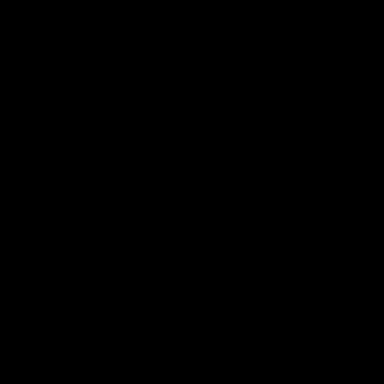

In [5]:
# let's look at one example (images are pretty high resolution)
example = train_ds[839]
image = example['image']
image

In [ ]:
import numpy as np
np.array(image).shape

In [ ]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])/255
segmentation_map = np.array(segmentation_map, dtype=np.uint8)
segmentation_map

In [ ]:
np.unique(segmentation_map)

In [5]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jaygala223/38-cloud-train-only-v2"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'non-cloud', 1: 'cloud'}


In [ ]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """

    #since we only have 2 classes
    return [[102, 255, 0], [92, 0, 255]]

palette = color_palette()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [6]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        # adding one bottom most pixel as 255 since processor/feature_extractor
        # wont take labels without a positive (i.e. class: 1 or cloud)
        uniques = np.unique(original_segmentation_map)
        if sum(uniques) == 0:
            original_segmentation_map[-1, -1] = 255

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [7]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    # A.LongestMaxSize(max_size=384),
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    # A.Resize(width=100, height=100),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])
# train_dataset = ImageSegmentationDataset(train_ds)
train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)
# test_dataset = ImageSegmentationDataset(test_ds)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# image, segmentation_map, _, _ = train_dataset[0]
image, segmentation_map, _, _ = train_dataset[222]
print(image.shape)
print(segmentation_map.shape)

In [8]:
from transformers import MaskFormerImageProcessor,Mask2FormerImageProcessor, AutoImageProcessor

# Create a preprocessor
# preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                   do_reduce_labels=False,
#                                                   do_resize=False, do_rescale=False, do_normalize=False)

size = {'longest_edge':384, 'shortest_edge':384}

#original
preprocessor = Mask2FormerImageProcessor(ignore_index=0,
                                        do_reduce_labels=False,
                                        do_resize=False,
                                        do_rescale=False,
                                        do_normalize=True,
                                        size=size)

#my experiment
# preprocessor = Mask2FormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [10]:

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# batch size more than 4 causes CUDA out of memory error

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [11]:
import torch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 384, 384])
pixel_mask torch.Size([2, 384, 384])
mask_labels torch.Size([1, 384, 384])
class_labels torch.Size([1])
original_images (384, 384, 3)
original_segmentation_maps (384, 384)


In [12]:
from transformers import MaskFormerForInstanceSegmentation, Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic",
#                                                             id2label=id2label,
#                                                             ignore_mismatched_sizes=True)


from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# finetuned_model = MaskFormerForInstanceSegmentation.from_pretrained("jaygala223/maskformer-finetuned-for-38-cloud-dataset",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

In [13]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation, AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image
import requests

size = {'longest_edge':384, 'shortest_edge':383}

# load MaskFormer fine-tuned on COCO panoptic segmentation
# feature_extractor = Mask2FormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-ade",
#                                                                size=size,
#                                                                )

# model 1 is for generating new pred segmentation maps... model 2 is to train on new pred labels

# image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-tiny")
image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-tiny",id2label=id2label, ignore_mismatched_sizes=True)

# model = UperNetForSemanticSegmentation.from_pretrained("jaygala223/upernet-swin-tiny-finetuned-for-38-cloud-dataset")
# model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-base")
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-tiny", id2label=id2label, ignore_mismatched_sizes=True)

# model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-tiny")

# load MaskFormer fine-tuned on COCO panoptic segmentation
# feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-ade",
#                                                                size={'longest_edge':384, 'shortest_edge':383},
#                                                                )

Some weights of UperNetForSemanticSegmentation were not initialized from the model checkpoint at openmmlab/upernet-swin-tiny and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 512, 1, 1]) in the checkpoint and torch.Size([2, 512, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import torch

def binarize_image(image, threshold = 50):
    """
    Binarizes a color image.

    Args:
        image (torch.Tensor): Input color image of shape [1, H, W, 3].
        threshold (float): Threshold value for binarization (between 0 and 255).

    Returns:
        torch.Tensor: Binarized image of shape [1, H, W].
    """
    image = image.float()
    # Convert the image to grayscale by taking the average across color channels
    gray_image = torch.mean(image, dim=3, keepdim=True)  # Shape: [1, H, W, 1]

    # Apply binarization based on the threshold
    binary_image = torch.where(gray_image >= threshold, torch.ones_like(gray_image), torch.zeros_like(gray_image))

    return binary_image.squeeze(dim=3)

In [ ]:
# import torch
# import torch.nn as nn

# class ThresholdModule(nn.Module):
#     def __init__(self):
#         super(ThresholdModule, self).__init__()
#         # Define a fully connected layer to learn the threshold value
#         self.fc = nn.Linear(3 * 384 * 384, 1)  # Input size is flattened image
#         # Initialize the threshold value to a reasonable starting point
#         nn.init.constant_(self.fc.weight, 0.5)  # You can adjust the initial value as needed
    
#     def forward(self, x):
#         # Flatten the input image
#         x = x.view(x.size(0), -1)
#         # Ensure that the data type matches (e.g., float32)
#         x = x.to(self.fc.weight.dtype)
#         # Apply the threshold module
#         threshold = torch.sigmoid(self.fc(x))  # Apply sigmoid to ensure it's in [0, 1]
#         return threshold

In [ ]:
# threshold_module = ThresholdModule()
# threshold_module.to(device)
# threshold = threshold_module(images.to(device))
# threshold.item()

In [ ]:
def maskformer_forward_pass(model, feature_extractor, images, labels, device):
    inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    inputs['pixel_values'] = inputs['pixel_values'].float()

    inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
    inputs['class_labels'] = torch.stack(inputs['class_labels']) 

    inputs.to(device)

    outputs = model(**inputs)
    
    return outputs

In [15]:
def upernet_forward_pass(model, image_processor, images, labels, device):
    inputs = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')
    inputs.to(device)

    outputs = model(**inputs)
    
    return outputs

In [ ]:
from torchvision.transforms import ToPILImage
import PIL.Image as Image

def display_tensor_as_pil(tensor):
    tensor = (tensor * 255).byte()

    # Convert the PyTorch tensor to a PIL image
    to_pil = ToPILImage()
    pil_image = to_pil(tensor)
    
    return pil_image

In [ ]:
display_tensor_as_pil(images.permute(0, 3, 1, 2)[0]/255)

In [ ]:
print(torch.sum(labels == 1))

display_tensor_as_pil(labels)

In [ ]:
print(torch.sum(new_labels == 1))

display_tensor_as_pil(new_labels)

In [ ]:
torch.sum(labels == 1).item()

In [16]:
device = "cuda"

batch = next(iter(train_dataloader))

images, labels = batch['original_images'], batch['original_segmentation_maps']

# first convert to np array then to tensor... because list to tensor is a slow operation
images = np.array(images)
images = torch.tensor(images)
labels = np.array(labels)
labels = torch.tensor(labels)/255

# print(images.shape)

images.to(device)
labels.to(device)
model.to(device)

new_labels = binarize_image(images, threshold=55)

# if there is only single cloud (i.e. 1) pixel then leave it
# or if all elements in new_labels are 1 then leave it (because image may have SNOW)
# note: binarization does poorly on snowy images.
# if (labels == 1).all().item() == 1 or (labels == 0).all().item() == 1:
#     new_labels = labels

outputs = upernet_forward_pass(model, image_processor,images, new_labels, device)

print("done!")

done!


In [17]:
outputs.loss

tensor(0.5629, device='cuda:0', grad_fn=<AddBackward0>)

TRAINING

In [26]:
torch.cuda.empty_cache()

In [27]:
#LEARNABLE BINARIZATION TRAINING

import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cuda"
model.to(device)

# threshold_module = ThresholdModule()
learnable_threshold = torch.nn.Parameter(torch.tensor(55.0))
# model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
model_optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': learnable_threshold}], lr=5e-5)


# threshold_optimizer = torch.optim.Adam(threshold_module.parameters(), lr=5e-5)
# scheduler = StepLR(optimizer, step_size=400, gamma=0.1)

running_loss = 0.0
num_samples = 0
for epoch in range(2):
  print("Epoch:", epoch)
  model.train()
  if_condition = 0
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      model_optimizer.zero_grad()
      torch.cuda.empty_cache()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)
      model.to(device)
#       threshold_module.to(device)
    
#       threshold = threshold_module(images.to(device))
    
      new_labels = binarize_image(images, threshold=55)

      # if there is only single cloud (i.e. 1) pixel then leave it
      # or if all elements in new_labels are 1 then leave it (because image may have SNOW)
      # note: binarization does poorly on snowy images.
#       if (labels == 1).all().item() == 1 or torch.sum(labels).item() < 10:
#           new_labels = labels
#           if_condition += 1

      outputs = upernet_forward_pass(model, image_processor,images, new_labels, device)

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 200 == 0:
        print("Loss:", running_loss/num_samples)
        evaluate(100)
#         print("Threshold: ", learnable_threshold)

      # Optimization
      model_optimizer.step()

Epoch: 0


  0%|          | 0/3780 [00:00<?, ?it/s]

Loss: 0.35627320408821106


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.15405376252640215
f1_score: 0.03686434518691265
recall: 0.029407361235781384
accuracy: 0.7045442856050795
mIoU:  0.018452180969063085
Loss: 0.12264616425474642


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8030330176500823
f1_score: 0.7438743282700448
recall: 0.7228562931487527
accuracy: 0.9692800792527135
mIoU:  0.4518564097640349
Loss: 0.09304076927456978


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8164766191066142
f1_score: 0.7864924410987716
recall: 0.7656974762422302
accuracy: 0.9807801367291603
mIoU:  0.4880669690889887
Loss: 0.07286624470360041


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8026146547239839
f1_score: 0.8039704304317595
recall: 0.8062599540940344
accuracy: 0.9846653366505189
mIoU:  0.5059158455322285
Loss: 0.0639940875164788


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8254713385328204
f1_score: 0.800214859201568
recall: 0.7781417696834098
accuracy: 0.9834508109010689
mIoU:  0.5015724460677345
Loss: 0.05802380029838257


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8139999348721644
f1_score: 0.8128451154580691
recall: 0.8122007847792072
accuracy: 0.9875059893681326
mIoU:  0.5166408148142371
Loss: 0.053040818730682116


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8319702964459033
f1_score: 0.8112697565081843
recall: 0.7935918104913566
accuracy: 0.9873573966279995
mIoU:  0.5146939692520859
Loss: 0.050887232913766095


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8264296622304045
f1_score: 0.8129367137530387
recall: 0.8017644639654098
accuracy: 0.9880046110076404
mIoU:  0.5169584389296499
Loss: 0.0479657360941767


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.809906783788976
f1_score: 0.8154876760617671
recall: 0.822987230703216
accuracy: 0.987708566998943
mIoU:  0.5208283303545254
Loss: 0.04565753075358109


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8346863876126935
f1_score: 0.8117093347464528
recall: 0.7934715097525081
accuracy: 0.9877034975222683
mIoU:  0.5156876817991091
Loss: 0.043751590038028323


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8243381419377418
f1_score: 0.8229114197808178
recall: 0.821653294702657
accuracy: 0.9903154194810652
mIoU:  0.529222420767171
Loss: 0.04218310331705041


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.82861936439372
f1_score: 0.823592347745092
recall: 0.8191099588952866
accuracy: 0.9906367101550544
mIoU:  0.5302277088792312
Loss: 0.040714082366340935


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8366162104702193
f1_score: 0.8153670380220355
recall: 0.7987224563892514
accuracy: 0.9887263231935073
mIoU:  0.5217139819443299
Loss: 0.03978733723019949


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8304113838708406
f1_score: 0.8245207265275242
recall: 0.8249042070810374
accuracy: 0.9902357179073923
mIoU:  0.5281859150313136
Loss: 0.03835494804649496


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8275286167433448
f1_score: 0.8250814771795812
recall: 0.8228948296945947
accuracy: 0.9909145913367269
mIoU:  0.533479419785856
Loss: 0.03730365933121909


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.839386890780941
f1_score: 0.8163426127129436
recall: 0.797076465392121
accuracy: 0.9884766095014353
mIoU:  0.5245352688402233
Loss: 0.03647857405237892


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8274537967517716
f1_score: 0.8236059569246011
recall: 0.8208667235350134
accuracy: 0.9906103555908864
mIoU:  0.5349985905508003
Loss: 0.03576968783186335


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8225080021659992
f1_score: 0.8292238142071064
recall: 0.8409592561301655
accuracy: 0.9909164042621603
mIoU:  0.5383138352322696
Loss: 0.03482441621552729


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8327692476798533
f1_score: 0.8259123682404257
recall: 0.8195107575132631
accuracy: 0.991270596175492
mIoU:  0.5364486962870354
Epoch: 1


  0%|          | 0/3780 [00:00<?, ?it/s]

Loss: 0.03414461023280978


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.820911830942586
f1_score: 0.8295697117753601
recall: 0.8433474976751218
accuracy: 0.9909554828770526
mIoU:  0.5420374926364068
Loss: 0.03361734168274754


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8283543938287475
f1_score: 0.8270937530522664
recall: 0.82596260277881
accuracy: 0.991499394079697
mIoU:  0.5416382938475892
Loss: 0.03318999889646032


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8395323754551937
f1_score: 0.8191338486747369
recall: 0.8021247259371095
accuracy: 0.9895738658335133
mIoU:  0.529629058601095
Loss: 0.032491829087578396


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8144424625016414
f1_score: 0.8251321626828765
recall: 0.8450493626712091
accuracy: 0.9906338900488249
mIoU:  0.5392920657771059
Loss: 0.0323041685845356


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8337470626216312
f1_score: 0.8260399361873955
recall: 0.8188265348681786
accuracy: 0.991352077101905
mIoU:  0.5354626557909616
Loss: 0.03189980677095852


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8329589136643765
f1_score: 0.8269632362944006
recall: 0.8213489931384899
accuracy: 0.9915732540047513
mIoU:  0.5394294395452679
Loss: 0.03143162088145039


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8294078234298758
f1_score: 0.8282028025931584
recall: 0.8271257755491026
accuracy: 0.9918667129160721
mIoU:  0.5423975795654967
Loss: 0.03110078055567132


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8290029158922524
f1_score: 0.8280357639887295
recall: 0.8271714945898904
accuracy: 0.9918859164965868
mIoU:  0.5417389689695717
Loss: 0.030777941045943853


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8403136820212025
f1_score: 0.8238422393684134
recall: 0.8089517662219267
accuracy: 0.9908240793558415
mIoU:  0.5342703146657141
Loss: 0.03038709283850136


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8310796585221906
f1_score: 0.8279000933612677
recall: 0.8249255901905536
accuracy: 0.9917744215824464
mIoU:  0.5416684850017623
Loss: 0.030071682997035474


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8338110023478108
f1_score: 0.8275341172708391
recall: 0.8217545469001617
accuracy: 0.9918229341241307
mIoU:  0.5426247021791959
Loss: 0.02982650610270595


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8305674945431786
f1_score: 0.8289471731160026
recall: 0.8274616102575746
accuracy: 0.9921329108005089
mIoU:  0.5446934917628174
Loss: 0.029591713889187


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.7636535234682277
f1_score: 0.7866022588364898
recall: 0.8444077481450275
accuracy: 0.9779652342672358
mIoU:  0.5036910580673444
Loss: 0.029542224365763207


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.83937114658992
f1_score: 0.8221905797619325
recall: 0.8071156143239471
accuracy: 0.9904379933839634
mIoU:  0.5288103638253737
Loss: 0.029190378716479292


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8317494373331211
f1_score: 0.8280830052042133
recall: 0.8246347511549765
accuracy: 0.9918724874193037
mIoU:  0.5419163780268466
Loss: 0.028905228216558363


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8307229849072206
f1_score: 0.8285633127200084
recall: 0.8265353775292029
accuracy: 0.9920318569939564
mIoU:  0.5440411086719815
Loss: 0.028678229953363266


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8299800441756355
f1_score: 0.8295377069335595
recall: 0.8353871025113755
accuracy: 0.9916719912954722
mIoU:  0.5399422349389826
Loss: 0.028392224759840674


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8330817527621778
f1_score: 0.8288066092357789
recall: 0.8247295997604112
accuracy: 0.9920905084889886
mIoU:  0.5445805830825673
Loss: 0.028092764234123893


  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.8363100626175723
f1_score: 0.8280005345493053
recall: 0.8201858004211655
accuracy: 0.991942117185015
mIoU:  0.5422774900009136


In [ ]:
#NORMAL TRAINING

import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cuda"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=400, gamma=0.1)

running_loss = 0.0
num_samples = 0
for epoch in range(3):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)
      model.to(device)

      inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#       print(inputs)
      # comment the mask labels and class labels for segformer
      inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
      inputs['class_labels'] = torch.stack(inputs['class_labels'])
      # comment the mask labels and class labels for segformer

      inputs['pixel_values'] = inputs['pixel_values'].float()
      inputs.to(device)

      outputs = model(**inputs)

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)
        if (running_loss/num_samples) <= 0.15:
          break

      # Optimization
      optimizer.step()

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [22]:
repo_name = "upernet-swin-tiny-38-cloud-dataset-binarization"
model.push_to_hub(repo_name)

pytorch_model.bin:   0%|          | 0.00/240M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jaygala223/upernet-swin-tiny-38-cloud-dataset-binarization/commit/02ae809ce58d022cce315a1173690488988d4e25', commit_message='Upload UperNetForSemanticSegmentation', commit_description='', oid='02ae809ce58d022cce315a1173690488988d4e25', pr_url=None, pr_revision=None, pr_num=None)

TESTING

In [84]:
# def calculate_iou(pred_mask_list, true_mask_list):
#     total_iou = 0.0
#     num_masks = len(pred_mask_list)

#     for pred_mask, true_mask in zip(pred_mask_list, true_mask_list):
#         pred_mask = pred_mask.cpu()
#         true_mask = true_mask.cpu()
#         intersection = torch.logical_and(pred_mask, true_mask).sum()
#         union = torch.logical_or(pred_mask, true_mask).sum()

#         iou = intersection.float() / union.float()
#         total_iou += iou.item()

#     avg_iou = total_iou / num_masks
#     return avg_iou

In [23]:
import torch

def calculate_metrics(true_labels, predicted_labels, device):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for true, predicted in zip(true_labels, predicted_labels):
        true.to(device)
        predicted.to(device)
        true_positives += torch.sum((predicted == 1) & (true == 1)).item()
        false_positives += torch.sum((predicted == 1) & (true == 0)).item()
        false_negatives += torch.sum((predicted == 0) & (true == 1)).item()
        true_negatives += torch.sum((predicted == 0) & (true == 0)).item()

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, accuracy, f1_score

# Example usage
true_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]
predicted_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]

precision, recall, accuracy, f1_score = calculate_metrics(true_labels, predicted_labels, "cuda")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Precision: 0.9999999750000006
Recall: 0.9999999750000006
Accuracy: 0.9999999833333336
F1 Score: 0.9999999250000032


In [22]:
# BINARIZATION IOU

import torch

def calculate_iou(list1, list2):
    """
    Calculate Intersection over Union (IoU) for corresponding binary masks in two lists.

    Args:
        list1 (list of PyTorch tensors): The first list of binary masks.
        list2 (list of PyTorch tensors): The second list of binary masks (same length as list1).

    Returns:
        list of floats: List of IoU scores for corresponding masks.
    """
    if len(list1) != len(list2):
        raise ValueError("Input lists must have the same length.")

    iou_scores = []

    for mask1, mask2 in zip(list1, list2):
        intersection = torch.sum(mask1 & mask2)
        union = torch.sum(mask1 | mask2)

        # Calculate IoU
        iou = intersection.float() / (union.float() + 1e-6)  # Add a small epsilon to avoid division by zero
        iou_scores.append(iou.item())

    return sum(iou_scores)/len(iou_scores)

# Example usage:
list1 = [torch.tensor([[1, 0], [1, 1]]), torch.tensor([[0, 1], [1, 0]])]
list2 = [torch.tensor([[1, 1], [0, 1]]), torch.tensor([[1, 0], [0, 1]])]

iou_scores = calculate_iou(list1, list2)
iou_scores

0.24999994039535522

In [135]:
from tqdm.auto import tqdm

def evaluate(num_batches):

    model.eval()
    device = "cuda"
    all_ious = []
    precisions, recalls, accuracies, f1_scores = [], [], [], []
    for idx, batch in enumerate(tqdm(test_dataloader)):
        if idx > num_batches:
            break
        images, labels = batch['original_images'], batch['original_segmentation_maps']

        images = np.array(images)
        images = torch.tensor(images)
        labels = np.array(labels)
        labels = torch.tensor(labels)/255

        images.to(device)
        labels.to(device)
        model.to(device)

    #     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
    # #     print(inputs)

    #     ##### comment these 2 lines for segformer... keep otherwise ####
    #     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
    #     inputs['class_labels'] = torch.stack(inputs['class_labels'])
    #     ##### comment these 2 lines for segformer... keep otherwise ####


    #     inputs['pixel_values'] = inputs['pixel_values'].float()
    #     inputs.to(device)

        # Forward pass
        with torch.no_grad():
          # outputs = model(pixel_values=pixel_values.to(device))
    #       threshold = threshold_module(images.to(device))

    #       new_labels = binarize_image(images, threshold=55)

          # if there is only single cloud (i.e. 1) pixel then leave it
          # or if all elements in new_labels are 1 then leave it (because image may have SNOW)
          # note: binarization does poorly on snowy images.
    #       if (labels == 1).all().item() == 1 or torch.sum(labels).item() < 10:
    #           new_labels = labels
    #           if_condition += 1
          new_labels = binarize_image(images, threshold=55)

          outputs = upernet_forward_pass(model, image_processor,images, new_labels, device)



        # get original images
        # original_images = batch["original_images"]
        target_sizes = [(image.shape[0], image.shape[1]) for image in images]
        # predict segmentation maps
        predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs,
                                                                                      target_sizes=target_sizes)

        labels = new_labels.to(device)

        for preds in predicted_segmentation_maps:
            preds.int()
            preds.to(device)
        for label in labels:
            label.int()
            label.to(device)

        #for mean iou calculation... pred maps and labels must be same shape
        labels_list = []

        for i in range(labels.size(0)):
            labels[i].int()
            labels[i].to(device)
            labels_list.append(labels[i].int().to(device))

    #     print(predicted_segmentation_maps, labels_list)
        all_ious.append(calc_iou(predicted_segmentation_maps, labels))
        precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1_scores.append(f1_score)

    print("precision:", sum(precisions)/ len(precisions))
    print("f1_score:", sum(f1_scores)/ len(f1_scores))
    print("recall:", sum(recalls)/ len(recalls))
    print("accuracy:", sum(accuracies)/ len(accuracies))
    print("mIoU: ", sum(all_ious)/len(all_ious))
    
    return predicted_segmentation_maps, new_labels

In [127]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(num_classes=2, task='binary')

def calc_iou(maps, labels):    
    maps = torch.stack(maps)
    
    iou_scores = []
    
    for i in range(len(maps)):
        iou = jaccard(maps[i].cpu(), labels[i].cpu())
        if torch.isnan(iou) == False:
            iou_scores.append(iou.item())
    
    return sum(iou_scores)/(len(iou_scores)+ 1e-5)

In [105]:
print(calc_iou(pred_maps[0], new_labels[0]))

0.9999999999932183


In [107]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(num_classes=2, task='binary')
print(jaccard(pred_maps[1].cpu(), new_labels[1].cpu()))

tensor(nan)


In [143]:
pred_maps, new_labels = evaluate(28)

  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.9171099027541035
f1_score: 0.9136387422361115
recall: 0.9102561619395113
accuracy: 0.9939329651577092
mIoU:  0.8802076108027126


In [89]:
# from tqdm.auto import tqdm

# model.eval()
# device = "cuda"
# all_ious = []
# precisions, recalls, accuracies, f1_scores = [], [], [], []
# for idx, batch in enumerate(tqdm(test_dataloader)):
#     if idx > 100:
#         break
#     images, labels = batch['original_images'], batch['original_segmentation_maps']

#     images = np.array(images)
#     images = torch.tensor(images)
#     labels = np.array(labels)
#     labels = torch.tensor(labels)/255

#     images.to(device)
#     labels.to(device)
#     model.to(device)

# #     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
# # #     print(inputs)

# #     ##### comment these 2 lines for segformer... keep otherwise ####
# #     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
# #     inputs['class_labels'] = torch.stack(inputs['class_labels'])
# #     ##### comment these 2 lines for segformer... keep otherwise ####


# #     inputs['pixel_values'] = inputs['pixel_values'].float()
# #     inputs.to(device)

#     # Forward pass
#     with torch.no_grad():
#       # outputs = model(pixel_values=pixel_values.to(device))
# #       threshold = threshold_module(images.to(device))
    
# #       new_labels = binarize_image(images, threshold=55)

#       # if there is only single cloud (i.e. 1) pixel then leave it
#       # or if all elements in new_labels are 1 then leave it (because image may have SNOW)
#       # note: binarization does poorly on snowy images.
# #       if (labels == 1).all().item() == 1 or torch.sum(labels).item() < 10:
# #           new_labels = labels
# #           if_condition += 1
#       new_labels = binarize_image(images, threshold=55)


#       outputs = upernet_forward_pass(model, image_processor,images, new_labels, device)
      


#     # get original images
#     # original_images = batch["original_images"]
#     target_sizes = [(image.shape[0], image.shape[1]) for image in images]
#     # predict segmentation maps
#     predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs,
#                                                                                   target_sizes=target_sizes)

#     labels = new_labels.to(device)
    
#     for preds in predicted_segmentation_maps:
#         preds.int()
#         preds.to(device)
#     for label in labels:
#         label.int()
#         label.to(device)

#     #for mean iou calculation... pred maps and labels must be same shape
#     labels_list = []

#     for i in range(labels.size(0)):
#         labels[i].int()
#         labels[i].to(device)
#         labels_list.append(labels[i].int().to(device))

# #     print(predicted_segmentation_maps, labels_list)
#     all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
#     precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
#     precisions.append(precision)
#     recalls.append(recall)
#     accuracies.append(accuracy)
#     f1_scores.append(f1_score)

# print("precision:", sum(precisions)/ len(precisions))
# print("f1_score:", sum(f1_scores)/ len(f1_scores))
# print("recall:", sum(recalls)/ len(recalls))
# print("accuracy:", sum(accuracies)/ len(accuracies))
# print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/420 [00:00<?, ?it/s]

precision: 0.777775369899725
f1_score: 0.77591650299546
recall: 0.7760544411086487
accuracy: 0.9873595452803645
mIoU:  0.5175349706470376


In [72]:
new_labels.int()

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.int32)

In [55]:
predicted_segmentation_maps[0].shape

torch.Size([384, 384])

In [53]:
labels[0] == new_labels[0]

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

In [ ]:
# swin tiny on PURELY NEW binarized LABELS
precision: 0.6152504039786425
f1_score: 0.5057209783787969
recall: 0.5720778575727808
accuracy: 0.8178325834725649
mIoU:  0.32597860723862077
    
# finetuned swin tiny on new binarized labels
precision: 0.751474905449785
f1_score: 0.6871745700037046
recall: 0.7321195578032763
accuracy: 0.8671422080385202
mIoU:  0.4677533339624049

In [ ]:
# MASKFORMER BEFORE LEARNABLE BINARIZATION
precision: 0.6140759422455014
f1_score: 0.6176200393516758
recall: 0.6242902578278914
accuracy: 0.9839068029674147
mIoU:  0.5901235823447888
    
# MASKFORMER AFTER LEARNABLE BINARIZATION


# last run
precision: 0.3062933478075279
f1_score: 0.34323185572017495
recall: 0.969535284181396
accuracy: 0.373442743152472
mIoU:  0.3061436470183687

precision 0.7754642685034004
f1_score 0.7528422777953474
recall 0.7397811585765738
accuracy 0.9775063871126577
mIoU:  0.7168471569364722

precision 0.5217402294425123
f1_score 0.5894180085336521
recall 0.999999981816197
accuracy 0.5217402294425123
mIoU:  0.521740224174788

* precision 0.3111225918183273
* f1_score 0.3191659886291905
* recall 0.3295510091217397
* accuracy 0.9829524113575062
* mIoU:  0.29805679046190703

* precision 0.26088595055841357
* f1_score 0.29013017962476445
* recall 0.3274049580908574
* accuracy 0.988511827256274
* mIoU:  0.25725841522216797

